In [14]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime

# download the dataset here: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [3]:
raw_data = pd.read_csv("beijing_pm25.csv")
raw_data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [9]:
print raw_data.isnull().sum()
print raw_data.shape
print float(raw_data['pm2.5'].isnull().sum())/raw_data.shape[0]

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64
(43824, 13)
0.0471659364732


In [10]:
print min(raw_data['pm2.5'].dropna()), max(raw_data['pm2.5'].dropna()), raw_data['pm2.5'].dropna().median()

0.0 994.0 72.0


In [16]:
# Data Preprocessing

def str2time(time_str):
    return datetime.strptime(time_str, '%Y %m %d %H')

## combine year, month, day, hour into datetime
raw_data = pd.read_csv("beijing_pm25.csv", parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=str2time)
raw_data.drop('No', axis=1, inplace=True)  # the above step create a column 'No'

## rename columns
raw_data.columns = ['polution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
raw_data.index.name = 'date'

## impute NA with median
population_median = raw_data['polution'].dropna().median()
raw_data['polution'].fillna(population_median, inplace=True)

raw_data.head()

,polution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,72.0,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,72.0,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,72.0,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,72.0,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,72.0,-20,-12.0,1018.0,NW,12.97,0,0


In [17]:
# label encoding wnd_spd to integers

encoder = LabelEncoder()
raw_data['wnd_dir'] = encoder.fit_transform(raw_data['wnd_dir'])
print raw_data['wnd_dir'].unique()
raw_data.head()

[1 3 0 2]


,polution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,72.0,-21,-11.0,1021.0,1,1.79,0,0
2010-01-01 01:00:00,72.0,-21,-12.0,1020.0,1,4.92,0,0
2010-01-01 02:00:00,72.0,-21,-11.0,1019.0,1,6.71,0,0
2010-01-01 03:00:00,72.0,-21,-14.0,1019.0,1,9.84,0,0
2010-01-01 04:00:00,72.0,-20,-12.0,1018.0,1,12.97,0,0


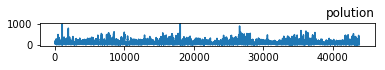

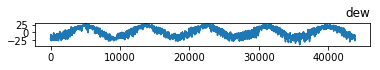

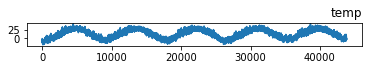

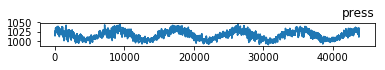

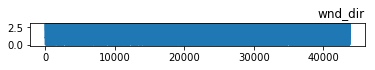

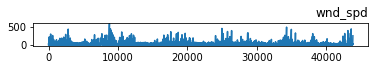

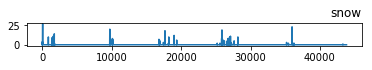

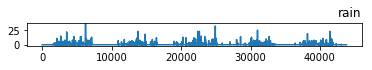

In [18]:
pyplot.figure()
col_nums = raw_data.shape[1]

for i in range(col_nums):
    pyplot.subplot(col_nums, 1, i+1)
    pyplot.plot(raw_data.values[:, i])
    pyplot.title(raw_data.columns[i], y=1, loc='right')  # y is the interval width between each plot
    pyplot.show()

In [19]:
# make sure all the data is float type
values = raw_data.values
values = values.astype('float32')
values

array([[  72.        ,  -21.        ,  -11.        , ...,    1.78999996,
           0.        ,    0.        ],
       [  72.        ,  -21.        ,  -12.        , ...,    4.92000008,
           0.        ,    0.        ],
       [  72.        ,  -21.        ,  -11.        , ...,    6.71000004,
           0.        ,    0.        ],
       ..., 
       [  10.        ,  -22.        ,   -3.        , ...,  242.69999695,
           0.        ,    0.        ],
       [   8.        ,  -22.        ,   -4.        , ...,  246.72000122,
           0.        ,    0.        ],
       [  12.        ,  -21.        ,   -3.        , ...,  249.8500061 ,
           0.        ,    0.        ]], dtype=float32)

In [20]:
# normalize the data into [0,1] range
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[ 0.0724346 ,  0.27941179,  0.13114753, ...,  0.00229001,
         0.        ,  0.        ],
       [ 0.0724346 ,  0.27941179,  0.1147541 , ...,  0.00763907,
         0.        ,  0.        ],
       [ 0.0724346 ,  0.27941179,  0.13114753, ...,  0.01069811,
         0.        ,  0.        ],
       ..., 
       [ 0.01006036,  0.2647059 ,  0.26229507, ...,  0.41399646,
         0.        ,  0.        ],
       [ 0.00804829,  0.2647059 ,  0.24590163, ...,  0.42086649,
         0.        ,  0.        ],
       [ 0.01207243,  0.27941179,  0.26229507, ...,  0.42621556,
         0.        ,  0.        ]], dtype=float32)

In [21]:
# Convert to supervided data
## Here, vari(t) is the 1 time step forard from vari(t-1)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  # number of columns in the original data
    df = pd.DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

forward_steps = 3
reframed = series_to_supervised(scaled, forward_steps, 1)  # Here is where different from one-step forward
reframed

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.072435,0.279412,0.131148,0.545454,0.333333,0.002290,0.000000,0.0,0.072435,0.279412,...,0.000000,0.0,0.072435,0.279412,0.081967,0.509090,0.333333,0.016047,0.000000,0.0
4,0.072435,0.279412,0.114754,0.527273,0.333333,0.007639,0.000000,0.0,0.072435,0.279412,...,0.000000,0.0,0.072435,0.294118,0.114754,0.490910,0.333333,0.021396,0.000000,0.0
5,0.072435,0.279412,0.131148,0.509090,0.333333,0.010698,0.000000,0.0,0.072435,0.279412,...,0.000000,0.0,0.072435,0.308824,0.147541,0.472727,0.333333,0.026745,0.000000,0.0
6,0.072435,0.279412,0.081967,0.509090,0.333333,0.016047,0.000000,0.0,0.072435,0.294118,...,0.000000,0.0,0.072435,0.308824,0.163934,0.472727,0.333333,0.032094,0.000000,0.0
7,0.072435,0.294118,0.114754,0.490910,0.333333,0.021396,0.000000,0.0,0.072435,0.308824,...,0.000000,0.0,0.072435,0.308824,0.163934,0.472727,0.333333,0.035153,0.000000,0.0
8,0.072435,0.308824,0.147541,0.472727,0.333333,0.026745,0.000000,0.0,0.072435,0.308824,...,0.000000,0.0,0.072435,0.308824,0.163934,0.472727,0.333333,0.040502,0.000000,0.0
9,0.072435,0.308824,0.163934,0.472727,0.333333,0.032094,0.000000,0.0,0.072435,0.308824,...,0.000000,0.0,0.072435,0.294118,0.180328,0.472727,0.333333,0.045851,0.000000,0.0
10,0.072435,0.308824,0.163934,0.472727,0.333333,0.035153,0.000000,0.0,0.072435,0.308824,...,0.000000,0.0,0.072435,0.308824,0.196721,0.472727,0.333333,0.052722,0.000000,0.0
11,0.072435,0.308824,0.163934,0.472727,0.333333,0.040502,0.000000,0.0,0.072435,0.294118,...,0.000000,0.0,0.072435,0.323529,0.229508,0.472727,0.333333,0.058071,0.000000,0.0
12,0.072435,0.294118,0.180328,0.472727,0.333333,0.045851,0.000000,0.0,0.072435,0.308824,...,0.000000,0.0,0.072435,0.308824,0.229508,0.436363,0.333333,0.063420,0.000000,0.0


In [24]:
# split into train and test sets
values = reframed.values
n_train_hours = 365*24*3  # raw_data has 4 years data reocred in hourly basis, here I'm using first 3 years as training
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

feature_num = raw_data.shape[1]  # number of features

# split into input and outputs
## predict multiple labels
train_X, train_y = train[:, :feature_num*forward_steps], train[:, -feature_num]  
test_X, test_y = test[:, :feature_num*forward_steps], test[:, -feature_num]

# reshape input to be 3D [samples, timesteps, dimensions]
train_X = train_X.reshape((train_X.shape[0], forward_steps, feature_num))  # Also different from one-step forward
test_X = test_X.reshape((test_X.shape[0], forward_steps, feature_num))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((26280, 3, 8), (26280,), (17541, 3, 8), (17541,))


In [25]:
# LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')  # using Mean Absolute Error here

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

Train on 26280 samples, validate on 17541 samples
Epoch 1/50
6s - loss: 0.0340 - val_loss: 0.0266
Epoch 2/50
6s - loss: 0.0187 - val_loss: 0.0208
Epoch 3/50
6s - loss: 0.0177 - val_loss: 0.0188
Epoch 4/50
6s - loss: 0.0160 - val_loss: 0.0180
Epoch 5/50
6s - loss: 0.0145 - val_loss: 0.0146
Epoch 6/50
6s - loss: 0.0138 - val_loss: 0.0153
Epoch 7/50
6s - loss: 0.0133 - val_loss: 0.0155
Epoch 8/50
6s - loss: 0.0133 - val_loss: 0.0145
Epoch 9/50
6s - loss: 0.0132 - val_loss: 0.0149
Epoch 10/50
6s - loss: 0.0131 - val_loss: 0.0147
Epoch 11/50
6s - loss: 0.0131 - val_loss: 0.0152
Epoch 12/50
6s - loss: 0.0130 - val_loss: 0.0146
Epoch 13/50
6s - loss: 0.0131 - val_loss: 0.0149
Epoch 14/50
6s - loss: 0.0133 - val_loss: 0.0144
Epoch 15/50
6s - loss: 0.0130 - val_loss: 0.0148
Epoch 16/50
6s - loss: 0.0131 - val_loss: 0.0140
Epoch 17/50
6s - loss: 0.0131 - val_loss: 0.0138
Epoch 18/50
6s - loss: 0.0132 - val_loss: 0.0143
Epoch 19/50
6s - loss: 0.0131 - val_loss: 0.0142
Epoch 20/50
6s - loss: 0.013

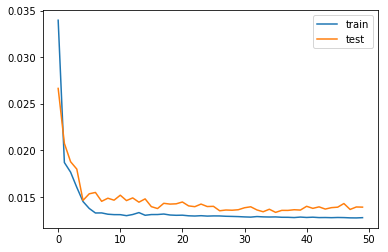

In [26]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [27]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], feature_num*forward_steps))  # Different from one-step forward

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(feature_num-1):]), axis=1)  # Predict multiple labels
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(feature_num-1):]), axis=1)  # Predict multiple labels
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.026
